In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
%matplotlib inline

# To do
- Scale data to make gradient descent better

### Fictisious dataset of weight(kg) vs obesity

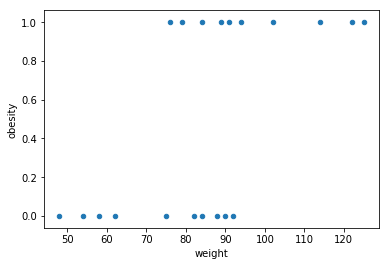

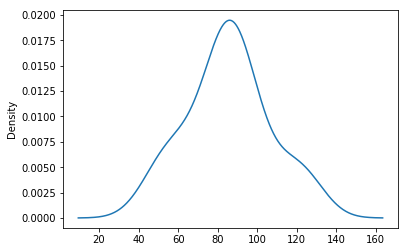

In [5]:
raw_data = [
    (48, 0),
    (54, 0),
    (58, 0),
    (62, 0),
    (75, 0),
    (82, 0),
    (84, 0),
    (88, 0),
    (90, 0),
    (92, 0),
    (76, 1),
    (79, 1),
    (84, 1),
    (89, 1),
    (91, 1),
    (94, 1),
    (102, 1),
    (114, 1),
    (122, 1),
    (125, 1),
       ]

data = pd.DataFrame(raw_data,columns=('weight','obesity'))
data.plot.scatter(x='weight',y='obesity')
plt.show()
data['weight'].plot.density()

### Randomise log odds linear coeffs
log(0.5) = 0 = 50% probability

In [6]:
def calc_probability_estimate(data, slope, intercept):
    data['log_odds'] = (data['weight'] * slope) + intercept
    try:
        math.exp(data['log_odds'].max())
    except OverflowError:
        return data, True
    data['probability'] = np.exp(data['log_odds']) / (1 + np.exp(data['log_odds']))
    return data, False


def calc_likelihood_or_error(data, slope, intercept, output='likelihood'):    
    data, calc_error = calc_probability_estimate(data, slope, intercept)
    if calc_error:
        return data, None
    data = data.sort_values('weight')   
    ## The error is negative(likelihood)
    ## Either method can be used to calculate either, but the first is a more intuitaive way to calculating it
    if output == 'likelihood':
        ## Calculate the likelihood of each data point, given our random fit
        obese = data['obesity'] == 1
        not_obese = data['obesity'] == 0
        data.loc[obese, 'likelihood'] = np.log(data['probability'])
        data.loc[not_obese, 'likelihood'] =  np.log(1 - data['probability'])
        likelihood_sum = data['likelihood'].sum()
        return data, round(likelihood_sum, 2)
    elif output == 'error':
        data['error'] = -(data['obesity']*np.log(data['probability']) + (1 - data['obesity'])*np.log(1 - data['probability']))
        error_sum = data['error'].sum()
        return data, round(error_sum, 2)

### Brute Force best fit

C:\Users\Jameshuckle\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,slope,intercept,likelihood_sum
153,0.15,-13,-9.55
232,0.10,-9,-9.61
252,0.10,-8,-9.69
74,0.20,-17,-10.19
331,0.05,-4,-10.23
...,...,...,...
637,0.35,11,-inf
638,0.40,11,-inf
639,0.45,11,-inf
656,0.30,12,-inf


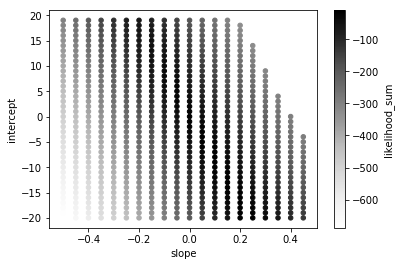

In [7]:
slope = 0.1
intercept = -10
fits = []

for intercept in np.arange(-20,20,1):
    for slope in np.arange(-0.5,0.5,0.05):
        data, likelihood_sum = calc_likelihood_or_error(data, slope, intercept, 'likelihood')
        if likelihood_sum is None:
            continue
        fits.append({'slope':slope, 'intercept':intercept, 'likelihood_sum':likelihood_sum})
        ## Plot ##                 
        #name = f'slope:{slope} | intercept:{intercept} | likelihood_product:{likelihood_product}'
        #data.plot(x='weight',y='probability', title = name)
best_fits = pd.DataFrame(fits)
best_fits.plot.scatter(x='slope', y='intercept', c='likelihood_sum')
best_fits.sort_values(by='likelihood_sum', ascending=False)

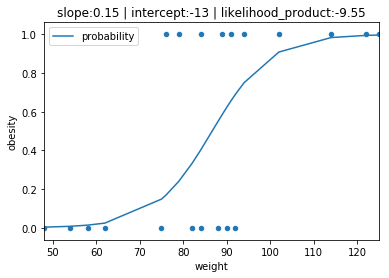

In [8]:
slope = 0.15
intercept = -13

data, likelihood_sum = calc_likelihood_or_error(data, slope=0.15, intercept=-13, output='likelihood')
name = f'slope:{slope} | intercept:{intercept} | likelihood_product:{likelihood_sum}'
ax = data.plot(x='weight',y='probability', title = name)
data.plot.scatter(x='weight',y='obesity', ax=ax)

### Gradient Descent

In [9]:
def derivative(data, slope, intercept):
    data, error_sum = calc_likelihood_or_error(data, slope, intercept, output='error')
    if error_sum is None:
        raise Exception(f'Slope term of {slope} or Intercept term of {intercept} is too large to compute')
    deriv_slope = ((data['probability'] - data['obesity']) * data['weight']).sum()
    deriv_intercept = (data['probability'] - data['obesity']).sum()
    return deriv_slope, deriv_intercept, error_sum

---------------------------------------------------------
slope: 0.1 | intercept: -1 | error_sum: 63.36
slope derivative: 729.83209 | intercept derivative: -1


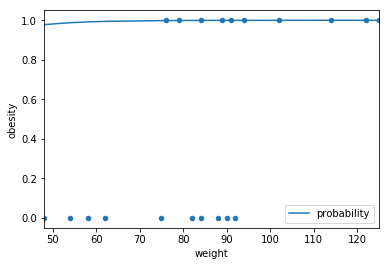

---------------------------------------------------------
slope: 0.09635 | intercept: -5.97222 | error_sum: 16.65
slope derivative: 482.84936 | intercept derivative: -5.97222


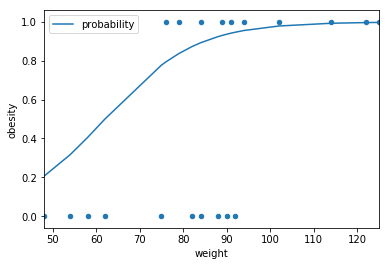

---------------------------------------------------------
slope: 0.09394 | intercept: -9.02386 | error_sum: 10.92
slope derivative: -283.88265 | intercept derivative: -9.02386


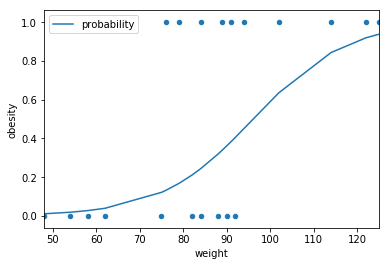

---------------------------------------------------------
slope: 0.09536 | intercept: -7.43041 | error_sum: 10.05
slope derivative: 181.17765 | intercept derivative: -7.43041


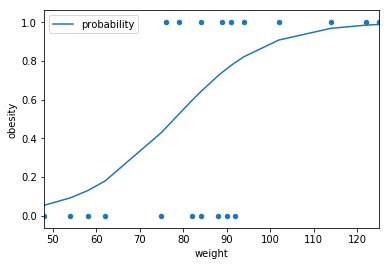

---------------------------------------------------------
slope: 0.09445 | intercept: -8.53765 | error_sum: 9.65
slope derivative: -140.19806 | intercept derivative: -8.53765


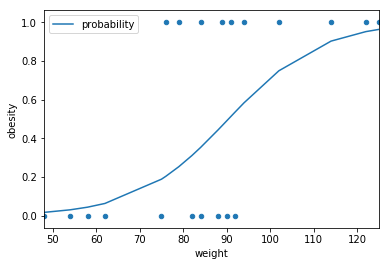

---------------------------------------------------------
slope: 0.09515 | intercept: -7.75277 | error_sum: 9.47
slope derivative: 93.51341 | intercept derivative: -7.75277


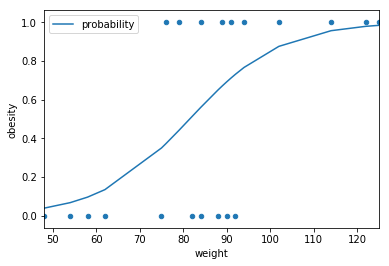

---------------------------------------------------------
slope: 0.09468 | intercept: -8.33134 | error_sum: 9.38
slope derivative: -76.90925 | intercept derivative: -8.33134


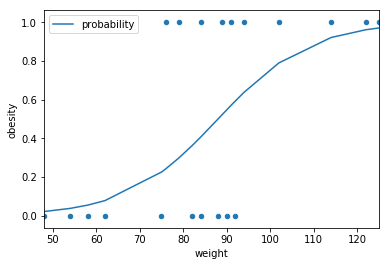

---------------------------------------------------------
slope: 0.09507 | intercept: -7.90969 | error_sum: 9.33
slope derivative: 49.29665 | intercept derivative: -7.90969


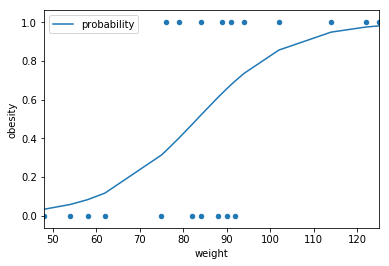

---------------------------------------------------------
slope: 0.09482 | intercept: -8.22543 | error_sum: 9.3
slope derivative: -43.92453 | intercept derivative: -8.22543


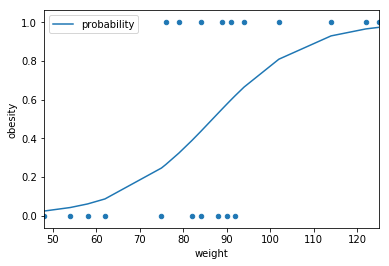

---------------------------------------------------------
slope: 0.09504 | intercept: -7.99472 | error_sum: 9.29
slope derivative: 25.38358 | intercept derivative: -7.99472


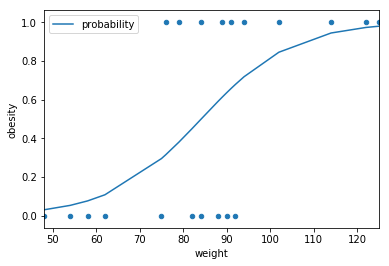

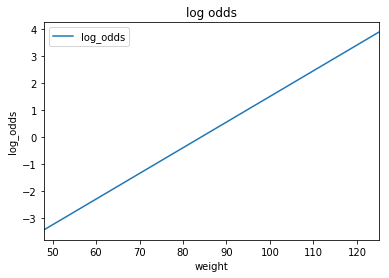

In [10]:
learning_rate_a = 0.000005
learning_rate_b = 0.5
slope = 0.1 # initial random
intercept = -1 # initial random

for _ in range(10):
    deriv_slope, deriv_intercept, error_sum = derivative(data, slope, intercept)
    ## plot chart ##
    print('---------------------------------------------------------')
    print(f'slope: {round(slope,5)} | intercept: {round(intercept,5)} | error_sum: {error_sum}')
    print(f'slope derivative: {round(deriv_slope,5)} | intercept derivative: {round(intercept,5)}')
    ax = data.plot(x='weight',y='probability')
    data.plot.scatter(x='weight',y='obesity', ax=ax) 
    plt.show()
    ## calc new slope and intercept ##
    slope -= learning_rate_a * deriv_slope
    intercept -= learning_rate_b * deriv_intercept
    
data.plot(x='weight',y='log_odds',title='log odds')
plt.ylabel('log_odds')
plt.show()

### Accuracy

In [36]:
from sklearn.metrics import accuracy_score

pred_data, error = calc_probability_estimate(data, slope =0.09504, intercept=-7.99472)
obese = pred_data['probability'] >= 0.5
pred_data.loc[obese, 'prediction'] = 1
pred_data.loc[~obese, 'prediction'] = 0
accuracy = accuracy_score(pred_data['obesity'], pred_data['prediction'])
print('Accuracy score:',accuracy)

Accuracy score: 0.7


In [37]:
pred_data.sort_index()

,weight,obesity,log_odds,probability,likelihood,prediction,overall_probability
0,48,0,-3.43280,0.031286,-0.003023,0.0,0.5
1,54,0,-2.86256,0.054036,-0.007419,0.0,0.5
2,58,0,-2.48240,0.077101,-0.013477,0.0,0.5
3,62,0,-2.10224,0.108879,-0.024423,0.0,0.5
4,75,0,-0.86672,0.295937,-0.160224,0.0,0.5
5,82,0,-0.20144,0.449810,-0.403186,0.0,0.5
6,84,0,-0.01136,0.497160,-0.513015,0.0,0.5
7,88,0,0.36880,0.591169,-0.798139,1.0,0.5
8,90,0,0.55888,0.636193,-0.974077,1.0,0.5
9,92,0,0.74896,0.678952,-1.171101,1.0,0.5


### McFaddens's Pseudo R-Squared

In [23]:
obese = (data['obesity'] == 1).sum()
not_obese = (data['obesity'] == 0).sum()
data['overall_probability'] = obese / (obese + not_obese)
ll_overall_prob = (data['obesity']*np.log(data['overall_probability']) + (1 - data['obesity'])*np.log(1 - data['overall_probability'])).sum()
ll_fit = (data['obesity']*np.log(data['probability']) + (1 - data['obesity'])*np.log(1 - data['probability'])).sum()
print('ll overall probability:',ll_overall_prob)
print('ll fit', ll_fit)

ll overall probability: -13.862943611198906
ll fit -9.28526634197857


In [24]:
r2 = 1 - (ll_fit / ll_overall_prob)
print('R2:', r2)

R2: 0.33020961475471555


### Chi Squared P-value

In [25]:
chi_squared = 2*(ll_fit - ll_overall_prob)
print('chi_squared:',chi_squared)
print('degrees of freedom:',1)

chi_squared: 9.155354538440672
degrees of freedom: 1


chi_squared_p_value: 0.00132


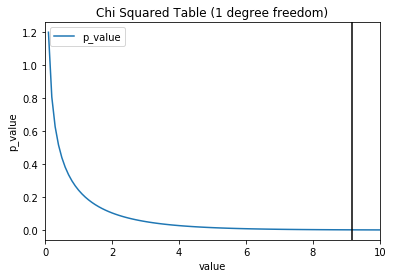

In [26]:
from scipy.stats import chi2
x = list(np.arange(0,10.1,0.1))
chi_table = pd.DataFrame(x, columns=['value'])
chi_table['p_value'] = chi_table['value'].map(lambda x: chi2.pdf(x, df=1))
p_value = chi_table[chi_table['value'] > chi_squared].head(1)['p_value'].round(5).values[0]
ax = chi_table.plot(x='value',y='p_value',title='Chi Squared Table (1 degree freedom)')
ax.set_ylabel('p_value')
ax.axvline(chi_squared, color='k')

print('chi_squared_p_value:',p_value)